# How to efficiently compute a functional map with a forward pass?

In [1]:
import gs.backend as gs

from geomfum.dataset import NotebooksDataset
from geomfum.descriptor.pipeline import (
    ArangeSubsampler,
    DescriptorPipeline,
    L2InnerNormalizer,
)
from geomfum.descriptor.spectral import HeatKernelSignature, LandmarkHeatKernelSignature
from geomfum.forward_functional_map import ForwardFunctionalMap
from geomfum.shape import TriangleMesh


[Load meshes](00_load_mesh_from_file.ipynb).

In [2]:
dataset = NotebooksDataset()

mesh_a = TriangleMesh.from_file(dataset.get_filename("cat-00"))
mesh_b = TriangleMesh.from_file(dataset.get_filename("lion-00"))

INFO: Data has already been downloaded... using cached file ('/home/ubuntu/.geomfum/data/cat-00.off').
/home/ubuntu/giulio_vigano/geomfum_proj/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Data has already been downloaded... using cached file ('/home/ubuntu/.geomfum/data/lion-00.off').


[Set Laplace eigenbasis](./02_mesh_laplacian_spectrum.ipynb) for each mesh.

In [3]:
mesh_a.laplacian.find_spectrum(spectrum_size=100, set_as_basis=True)
mesh_b.laplacian.find_spectrum(spectrum_size=100, set_as_basis=True)

# I decide to use just the first 10 eigenfunctions
mesh_a.basis.use_k = 10
mesh_b.basis.use_k = 8


Set a [descriptor pipeline](./04_descriptor_pipeline.ipynb) and apply it to both shapes.

In [4]:
mesh_a.landmark_indices = gs.array([2840, 1594, 5596, 6809, 3924, 7169])
mesh_b.landmark_indices = gs.array([1334, 834, 4136, 4582, 3666, 4955])
steps = [
    HeatKernelSignature.from_registry(n_domain=100),
    LandmarkHeatKernelSignature.from_registry(n_domain=100),
    ArangeSubsampler(subsample_step=1),
    L2InnerNormalizer(),
]

pipeline = DescriptorPipeline(steps)

descr_a = pipeline.apply(mesh_a)
descr_b = pipeline.apply(mesh_b)

Solve for the functional map matrix performing the forward pass.

In [5]:
ffm = ForwardFunctionalMap(lmbda=1e3, resolvent_gamma=1)
fmap, fmap21 = ffm(mesh_a, mesh_b, descr_a, descr_b)

Visualize the map

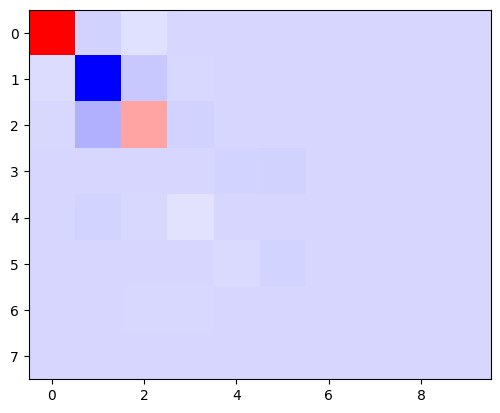

In [6]:
import matplotlib.pyplot as plt

plt.imshow(fmap, "bwr")


## Further reading

* [How to compute a pointwise map from a functional map?](./10_pointwise_from_functional.ipynb)

* [How to refine a functional map?](./15_refine_functional_map.ipynb)

* [How to use ReMatching to compute a functional map?](./13_rematching.ipynb)